In [90]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import wrangle #acquire, prep and clean library
import env
import explore
import evaluate

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from math import sqrt
from datetime import date #remove for final project as it is in the wrangle.py

# Notes

# Executive Summary

- Bathrooms, bedrooms and square footage where the primary features that drove tax values followed by location.
- With more time I would like to have explore more single units, age and property type.

# Planning

- I want to find out if tax values differ for each of the following scenarios:
    - tax value to number of bathrooms
    - tax value to number of bedrooms
    - tax value to square footage
    - tax value to county

# Data Acquisition

- Predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

In [2]:
df = wrangle.get_zillow_data()
df.head(2)

,bathroomcnt,bedroomcnt,fips,yearbuilt,taxvaluedollarcnt,taxamount,calculatedfinishedsquarefeet
0,2.0,3.0,6037.0,1923.0,205123.0,2627.48,1316.0
1,2.0,3.0,6037.0,1970.0,136104.0,2319.90,1458.0


##### Acquired dataset
1. Queried single family homes from "hot months" May to August 2017 as stated in the project scenario.

# Data Preparation

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.describe().T

In [3]:
df['age'] = date.today().year - df.yearbuilt
df['tax_rate'] = (df['taxamount'] / df['taxvaluedollarcnt'])
df = df.drop(columns=['yearbuilt', 'taxamount'])
df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet":"square_feet",
                        "taxvaluedollarcnt":"tax_value", "fips":"county_code"})

df['tax_rate'] = df.tax_rate.fillna(value = df['tax_rate'].mean())
df['tax_value'] = df.tax_value.fillna(value = df['tax_value'].mean())
df['square_feet'] = df.square_feet.fillna(value = df['square_feet'].mean())
df['age'] = df.age.fillna(value = df['age'].mean())

#converts floats to int 
convert_dict_int = {'county_code': int, 'bathrooms': int, 'bedrooms': int, 'tax_value':int, 'square_feet':int, 
                    'age':int}
df = df.astype(convert_dict_int)


In [ ]:

df.head()

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
#prior to removing outliers
#had to add 'transaction_date' to the drop column within the function
wrangle.get_hist(df)

In [ ]:
#prior to removing outliers
wrangle.get_box(df)

In [4]:
#remove outliers
k = 1.5
col_list = ['bathrooms', 'bedrooms', 'tax_value', 'tax_rate', 'square_feet', 'age']
df = wrangle.remove_outliers(df, k , col_list)
df.head()

,bathrooms,bedrooms,county_code,tax_value,square_feet,age,tax_rate
0,2,3,6037,205123,1316,98,0.012809
2,1,2,6037,35606,1421,110,0.015270
3,3,4,6059,880456,2541,18,0.011153
4,2,3,6037,107110,1491,66,0.013064
5,2,3,6037,614000,1650,72,0.012497


In [ ]:
#after removing outliers
wrangle.get_hist(df)

In [ ]:
#after removing outliers
wrangle.get_box(df)

##### NOTES

1. SQL zillow dataset
2. property type - Single Family - 261
3. .shape (2152863, 61)
4. After initial data acquisition .shape (2152863, 16)
    - From initial acquisition I kept the following columns:
    - parcelid, basementsqft, bathroomcnt, bedroomcnt, fips, garagecarcnt, garagetotalsqft, lotsizesquarefeet, poolcnt, poolsizesum, roomcnt, unitcnt, yearbuilt, numberofstories, taxvaluedollarcnt, taxamount
5. Dropped (based on qty of nulls): basementsqft, garagetotalsqft, poolcnt, poolsizesum, unitcnt, numberofstories, roomcnt
6. Final .shape (2152985, 11)
7. Drop duplicates (2152982, 11) 
8. Fill in nulls (as identified in wrangle.py)
9. Drop columns
10. Visualize
11. Remove outliers
12. After prep'd data I queried "hot months" from sql
    - shape after query (28124, 12)
    - null counts show different numbers and prep function will need to be modified
    - no change in shape after dropping duplicates
    - modified prep function
    - modified outliersw
    
##### NOTES on Project Guidance
- The below, prior to data exploration, is built to project guidance.

## MVP

# Split data

In [5]:
train, validate, test = wrangle.train_validate_test_split(df)
print(f'train: {train.shape}')
print(f'validate: {validate.shape}')
print(f'test: {test.shape}')

train: (12348, 7)
validate: (5292, 7)
test: (4410, 7)


# Data Exploration

1. What are the takeaways about the drivers of single unit property values?
    - County code 6037 makes up 61.17 percent of "hot_months" properties.
    - Three bedrooms, 2 bath homes of an average of 1745 make up the majority of properties.
    - Average tax value for these home is 408,247 dollars.
    - Average ages of the homes is 58 years.
    - Average tax rate is 1.25 percent.

2. Visualizations to support main points.

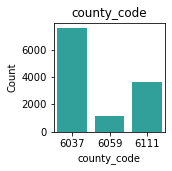

      county_code  Count  Percent
6037         6037   7548    61.13
6059         6111   3611    29.24
6111         6059   1189     9.63


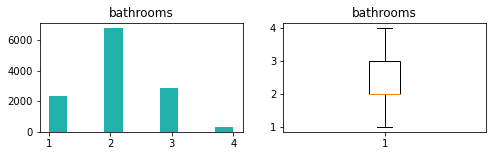

count    12348.000000
mean         2.099206
std          0.722739
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: bathrooms, dtype: float64


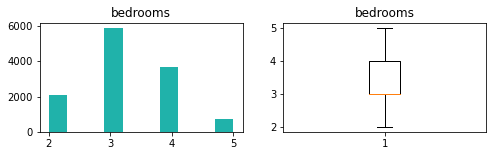

count    12348.000000
mean         3.244250
std          0.798544
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: bedrooms, dtype: float64


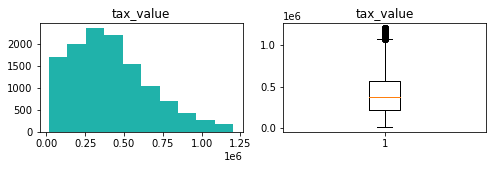

count    1.234800e+04
mean     4.163668e+05
std      2.525879e+05
min      1.608400e+04
25%      2.229975e+05
50%      3.811420e+05
75%      5.644125e+05
max      1.204898e+06
Name: tax_value, dtype: float64


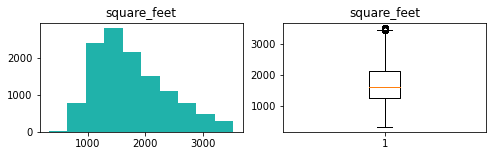

count    12348.000000
mean      1753.299563
std        623.510051
min        326.000000
25%       1273.000000
50%       1628.500000
75%       2142.000000
max       3524.000000
Name: square_feet, dtype: float64


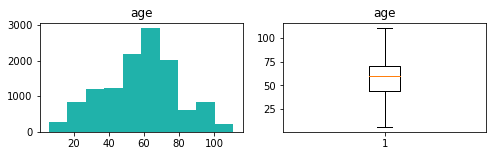

count    12348.000000
mean        58.181406
std         21.069838
min          6.000000
25%         44.000000
50%         60.000000
75%         71.000000
max        111.000000
Name: age, dtype: float64


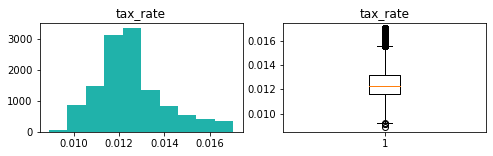

count    12348.000000
mean         0.012511
std          0.001496
min          0.008908
25%          0.011587
50%          0.012262
75%          0.013175
max          0.017044
Name: tax_rate, dtype: float64


In [6]:
explore.explore_univariate(train, cat_vars = ['county_code'], quant_vars = ['bathrooms', 'bedrooms', 'tax_value', 
                                                                            'square_feet', 'age', 'tax_rate'])

# Initial Hypothesis and Testing

### Bivariate

- County Code 6059 has the tax value at 468,487 dollars, followed by 6111 at 449,845 and 6037 at 386,158
- Tax values are higher for homes with 4 baths 635,958
- Tax values are higher for homes with 5 bedrooms 529,151

##### Hypothesis

- Do homes in 6059 have haigher tax values then the rest of the population?
- Do Homes with four baths have a higher tax value then the rest of the populations?
- Do home with five bedrooms have a higher tax value then the rest of the population?
- Do 5 bedroom/4 bath homes in 6059 have higher tax value then the rest of the population?


county_code vs tax_value


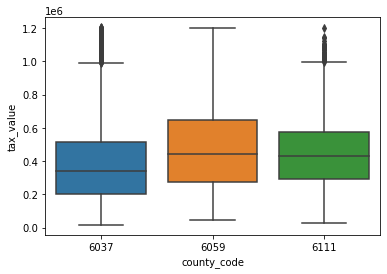

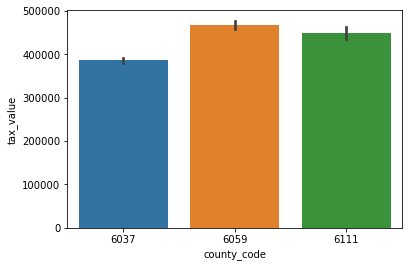

-------------------------------
Mean tax_value by county_code:  
county_code
6037    386158.489931
6059    468487.031847
6111    449845.395290
Name: tax_value, dtype: float64

bathrooms vs tax_value


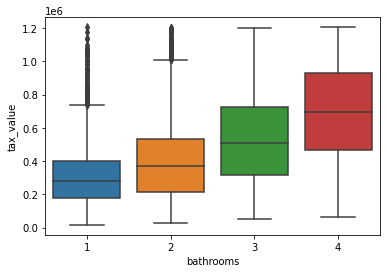

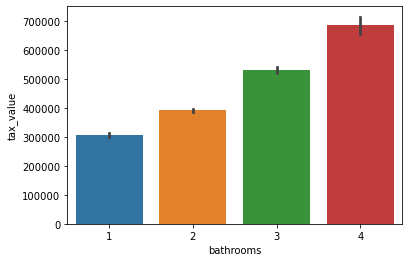

-------------------------------
Mean tax_value by bathrooms:  
bathrooms
1    307513.756838
2    391878.319510
3    530501.316316
4    685958.345345
Name: tax_value, dtype: float64

bedrooms vs tax_value


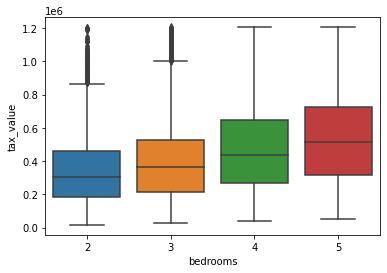

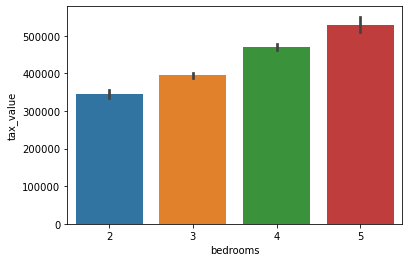

-------------------------------
Mean tax_value by bedrooms:  
bedrooms
2    345094.749880
3    394369.703306
4    470058.414879
5    529151.866197
Name: tax_value, dtype: float64



In [7]:
#exploring split
#FIPS VS TAX_value
explore.exp_bivariate_categorical('tax_value', ['county_code', 'bathrooms', 'bedrooms'], train)

### Multivariate

- Age of the home does not really play into the tax value of the home.
    - Homes between 40-75 years old range 
- Linear correlation between tax value and square footage of the home.
    - It is a small correlation, but noticeable (future feature not MVP but include in body and conclusion)

age vs tax_value


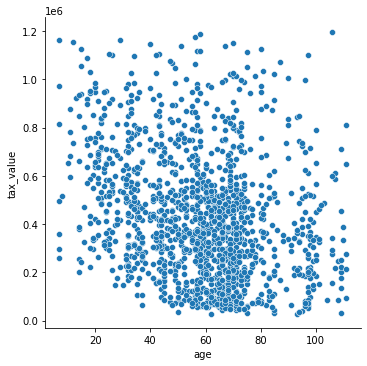

-------------------------------
Correlation between age and tax_value:  -0.2740760090911749
P value:  2.9615921974398993e-27

square_feet vs tax_value


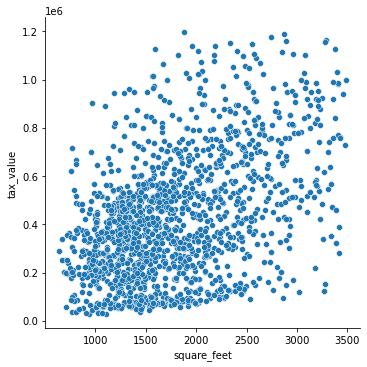

-------------------------------
Correlation between square_feet and tax_value:  0.457512478958131
P value:  1.803621933533215e-78



In [8]:
explore.exp_bivariate_continuous('tax_value', ['age', 'square_feet'], train.sample(1500))

# Hypothesis Testing
    - Do homes in 6059 have haigher tax values then the rest of the population?
    - Do Homes with four baths have a higher tax value then the rest of the populations?
    - Do home with five bedrooms have a higher tax value then the rest of the population?
    - Do 5 bedroom/ 4 bath homes in 6059 have higher tax value then the rest of the population?
    - Is the a positive linear correlation between tax value and square footage of the home.
    
I used a .05 alpha to test hypothesis.

In [9]:
alpha = .05

1. Do homes in 6059 have a higer tax values? (chi2)
    - Null: Tax value is independent of homes in 6059.
    - Alternate: Tax value is dependent of homes in 6059.

In [10]:
Null = 'Tax value is independent of homes in 6059.'
Alternate = 'Tax value is dependent of homes in 6059.'

observed = pd.crosstab(train.tax_value, train.county_code == 6059)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 11219.2770
p     = 0.0000


We reject the null and accept the alternate: Tax value is dependent of homes in 6059.


2. Do homes with three or more baths have a higher tax value? (chi2)
    - Null: Tax value is independentt of three or more baths.
    - Alternate: Tax value is dependent on three or more baths.

In [11]:
Null = 'Tax value is independentt of three or more bathrooms.'
Alternate = 'Tax value is dependent on three or more bathrooms.'

observed = pd.crosstab(train.tax_value, train.bathrooms >= 3)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 11051.7334
p     = 0.0010


We reject the null and accept the alternate: Tax value is dependent on three or more bathrooms.


3. Do home with four or more bedrooms have a higher tax value? (chi2)
    - Null: Tax value is independentt of four or more bedrooms.
    - Alternate: Tax value is dependent on four or more bedrooms.

In [12]:
Null = 'Tax value is independent of four or more bedrooms.'
Alternate = 'Tax value is dependent on four or more bedrooms.'

observed = pd.crosstab(train.tax_value, train.bedrooms >= 4)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 10857.0250
p     = 0.0373


We reject the null and accept the alternate: Tax value is dependent on four or more bedrooms.


4. Linear correlation between tax value and square footage of the home. (pearsonr)
    - Null: Tax value and square footage are NOT lineraly correlated.
    - Alternate: Tax value and square footage are lineraly correlated.

In [13]:
Null = 'Tax value and square footage are NOT lineraly correlated.'
Alternate = 'Tax value and square footage are lineraly correlated.'

corr, p = stats.pearsonr(train.tax_value, train.square_feet)

print(f'chi^2 = {corr:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 0.4500
p     = 0.0000


We reject the null and accept the alternate: Tax value and square footage are lineraly correlated.


# Multivatiate Exploration

Don't know if this is useful....


square_feet vs tax_value


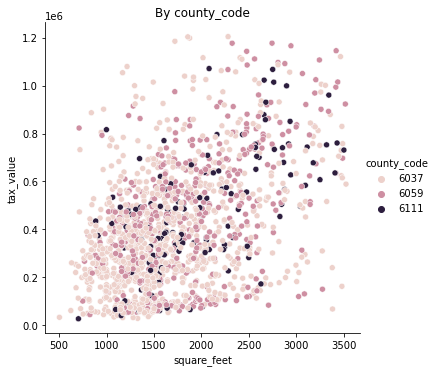

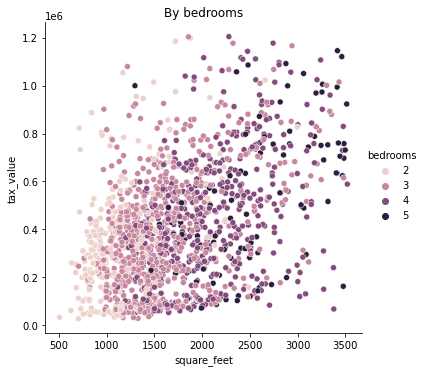

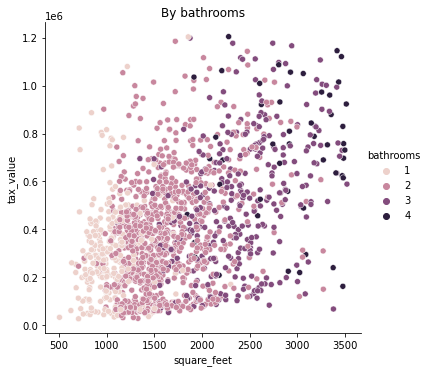


age vs tax_value


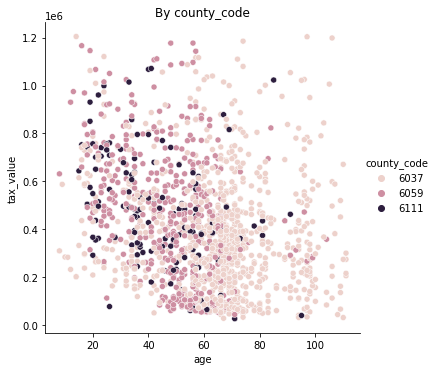

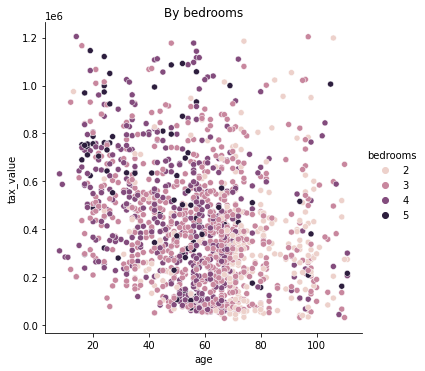

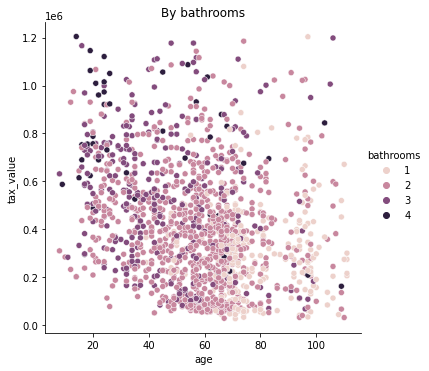

In [15]:
explore.exp_multivariate( ['square_feet', 'age'], ['county_code', 'bedrooms', 'bathrooms'], 
                         'tax_value', train.sample(1500))

# Modeling

In [16]:
X_train = train[['bedrooms', 'bathrooms', 'square_feet', 'county_code']]#features
y_train = train.tax_value
X_validate = validate[['bedrooms', 'bathrooms', 'square_feet', 'county_code']]#features
y_validate = validate.tax_value
X_test = test[['bedrooms', 'bathrooms', 'square_feet', 'county_code']]#features
y_test = test.tax_value

### Scaling

Text(0.5, 1.0, 'Scaled')

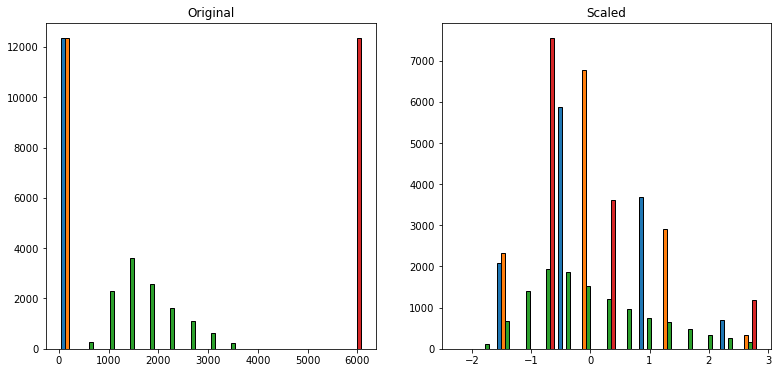

In [21]:
scaler = StandardScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=15, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=15, ec='black')
plt.title('Scaled')

In [74]:
X_train_scaled


array([[-1.55821161, -1.5209518 , -1.4119022 , -0.61570166],
       [-1.55821161, -0.13727002, -1.00611845, -0.61570166],
       [-0.30588169, -0.13727002, -0.22502483,  2.74454048],
       ...,
       [ 0.94644824,  1.24641176,  0.3892644 , -0.61570166],
       [-0.30588169, -0.13727002, -0.92592403,  0.38328925],
       [-0.30588169, -1.5209518 , -0.59712692, -0.61570166]])

### Feature Engineering

In [47]:
def rfe(x,y,k):
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=k)
    rfe.fit(X_train_scaled, y)
    return x.columns[rfe.get_support()]

In [49]:
rfe(X_train,y_train,1)

Index(['square_feet'], dtype='object')

In [31]:
rfe(X_train,y_train,4)

Index(['bedrooms', 'bathrooms', 'square_feet', 'county_code'], dtype='object')

In [22]:
def select_kbest(x,y,k):
    kbest = SelectKBest(f_regression, k=k)
    kbest.fit(X_train_scaled, y)
    features = kbest.get_support()
    return x.columns[kbest.get_support()]

In [29]:
select_kbest(X_train,y_train,1)

Index(['square_feet'], dtype='object')

In [30]:
select_kbest(X_train,y_train,4)

Index(['bedrooms', 'bathrooms', 'square_feet', 'county_code'], dtype='object')

### Regression Modeling

In [59]:
#baseline function calculates baseline and adds columns to the dataframe
evaluate.get_baseline(df, df[['square_feet']], df['tax_value'])

,bathrooms,bedrooms,county_code,tax_value,square_feet,age,tax_rate,yhat_baseline,yhat
3617,1,2,6037,103274,873,66,0.012373,416366.790492,255888.499545
19211,2,2,6037,863392,1126,74,0.012140,416366.790492,302010.307769
27983,2,3,6111,542000,1613,32,0.010956,416366.790492,390790.231109
20172,2,3,6037,257486,1466,69,0.012915,416366.790492,363992.184434
22141,1,3,6037,74798,1066,96,0.012125,416366.790492,291072.329534
...,...,...,...,...,...,...,...,...,...
27567,2,3,6037,212775,1392,80,0.011133,416366.790492,350502.011277
21173,3,4,6111,602135,3048,32,0.012748,416366.790492,652390.210562
5964,3,4,6037,274033,1996,65,0.013532,416366.790492,460610.992176
27850,2,3,6059,559527,1176,58,0.011369,416366.790492,311125.289631


In [61]:
evaluate.get_residuals(df, df['tax_value'])

,bathrooms,bedrooms,county_code,tax_value,square_feet,age,tax_rate,yhat_baseline,yhat,residual,residual_baseline
3617,1,2,6037,103274,873,66,0.012373,416366.790492,255888.499545,152614.499545,313092.790492
19211,2,2,6037,863392,1126,74,0.012140,416366.790492,302010.307769,-561381.692231,-447025.209508
27983,2,3,6111,542000,1613,32,0.010956,416366.790492,390790.231109,-151209.768891,-125633.209508
20172,2,3,6037,257486,1466,69,0.012915,416366.790492,363992.184434,106506.184434,158880.790492
22141,1,3,6037,74798,1066,96,0.012125,416366.790492,291072.329534,216274.329534,341568.790492
...,...,...,...,...,...,...,...,...,...,...,...
27567,2,3,6037,212775,1392,80,0.011133,416366.790492,350502.011277,137727.011277,203591.790492
21173,3,4,6111,602135,3048,32,0.012748,416366.790492,652390.210562,50255.210562,-185768.209508
5964,3,4,6037,274033,1996,65,0.013532,416366.790492,460610.992176,186577.992176,142333.790492
27850,2,3,6059,559527,1176,58,0.011369,416366.790492,311125.289631,-248401.710369,-143160.209508


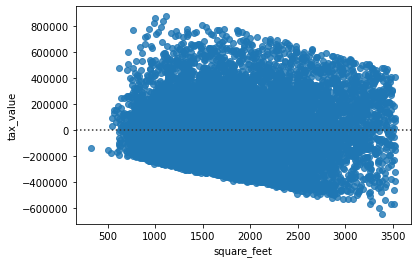

In [64]:
evaluate.plot_residual(df, df[['square_feet']], df['tax_value'])

In [65]:
evaluate.regression_errors(df, df['tax_value'], df.yhat)

(50876622990.17164,
 628224540682639.4,
 159521775363024.0,
 787746316045663.4,
 225558.4691164835)

In [67]:
evaluate.baseline_mean_errors(df, df['tax_value'], df.yhat_baseline)

(63795458053.58463, 787746316045663.0, 252577.62777725313)

In [68]:
evaluate.better_than_baseline(regression_errors = True, baseline_mean_errors = True)

The model is better then the baseline.


# Modeling Baseline

In [78]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute G3_pred_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  252577.63 
Validate/Out-of-Sample:  251230.56
RMSE using Median
Train/In-Sample:  255022.05 
Validate/Out-of-Sample:  252468.19


# LinearRegression (OLS)

In [88]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  224125.06629133702 
Validation/Out-of-Sample:  222786.8279825475


# LassoLars

In [91]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  224125.2585597165 
Validation/Out-of-Sample:  222785.17195160186


# TweedieRegressor (GLM)

In [92]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)



RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  252577.62777725313 
Validation/Out-of-Sample:  251230.5592725626


# Polynomial Regression

In [94]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  222773.07956697376 
Validation/Out-of-Sample:  221208.99610532908


# Plotting Actual vs. Predicted Values

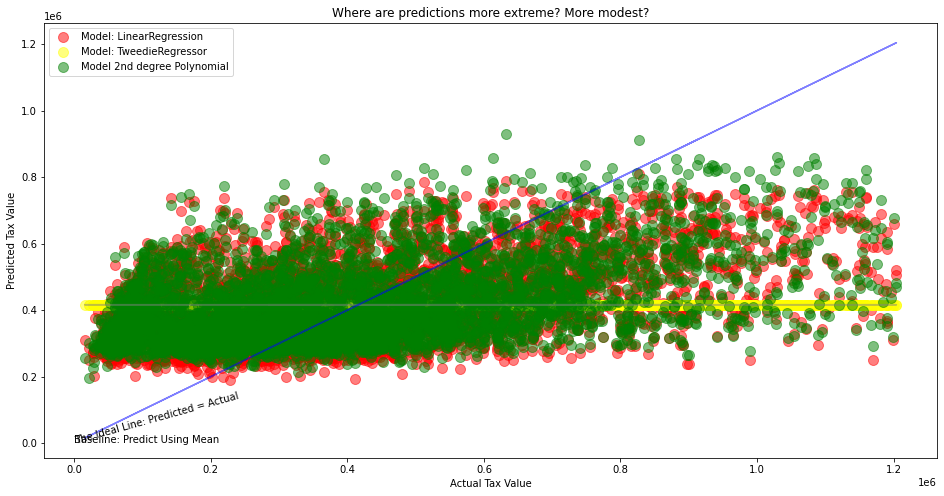

In [95]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# Residual Plots: Plotting the Errors in Predictions

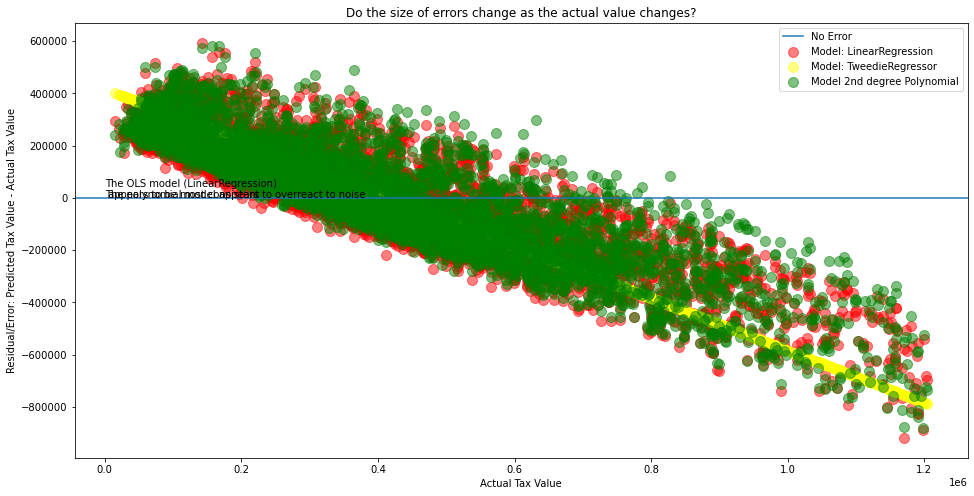

In [96]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# Histogram

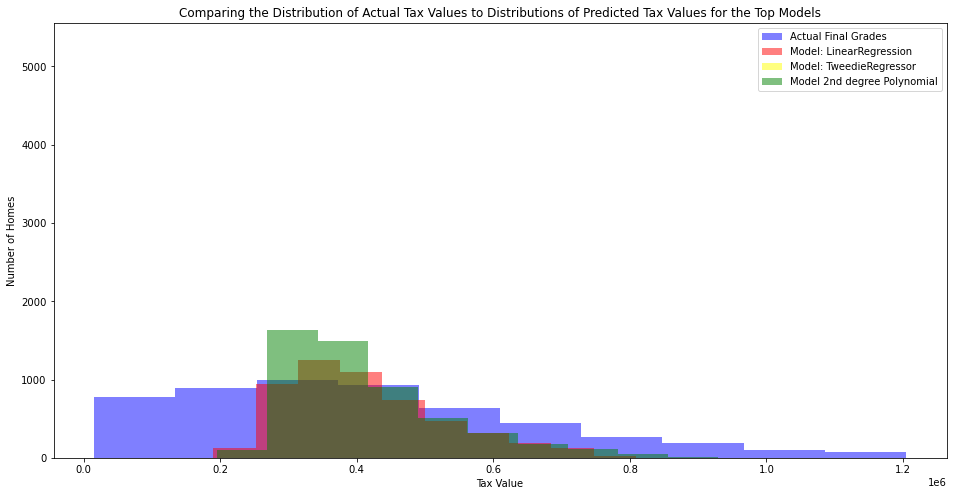

In [97]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

# Test

In [100]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_test_degree2 = pf.fit_transform(X_test)

# transform X_validate_scaled & X_test_scaled
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree2, y_test.tax_value)

# predict train
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test:  221666.78061644992


In [102]:
plot_residuals(y_test.tax_value, y_test.tax_value_pred_poly2)

AttributeError: module 'explore' has no attribute 'plot_residuals'

county_code vs tax_rate


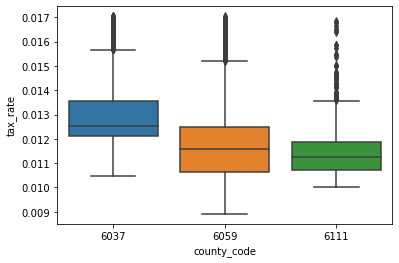

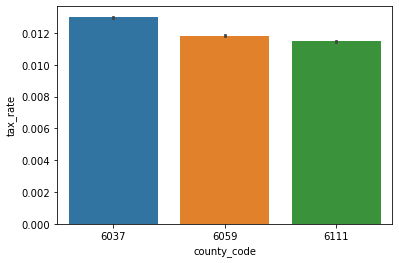

-------------------------------
Mean tax_rate by county_code:  
county_code
6037    0.012993
6059    0.011846
6111    0.011470
Name: tax_rate, dtype: float64



In [69]:
explore.exp_bivariate_categorical('tax_rate', ['county_code'], train)

In [72]:

county_6037 = df[df.county_code == 6037]
county_6059 = df[df.county_code == 6059]
county_6111 = df[df.county_code == 6111]

In [70]:
def plot_distributions(counties, x_value, group_key):
    
    for county in counties:
        sns.distplot(county[x_value])
        plt.title(county[group_key].unique())
        plt.show()
        print()
        print(county[x_value].describe())

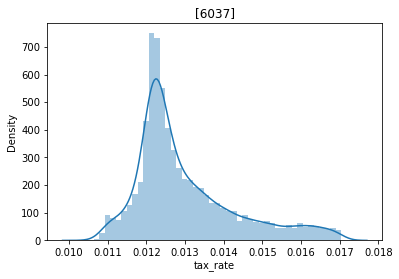


count    7548.000000
mean        0.012993
std         0.001315
min         0.010489
25%         0.012139
50%         0.012535
75%         0.013556
max         0.017044
Name: tax_rate, dtype: float64


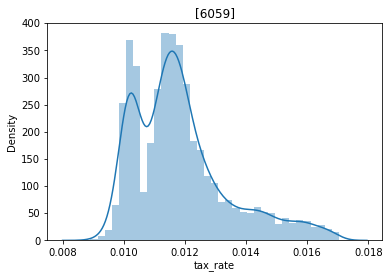


count    3611.000000
mean        0.011846
std         0.001566
min         0.008908
25%         0.010644
50%         0.011579
75%         0.012473
max         0.017039
Name: tax_rate, dtype: float64


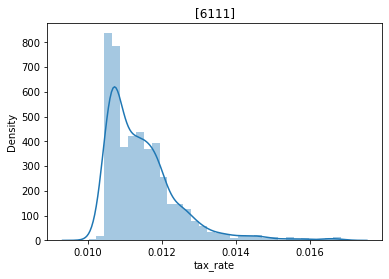


count    1189.000000
mean        0.011470
std         0.000967
min         0.010024
25%         0.010717
50%         0.011270
75%         0.011865
max         0.016841
Name: tax_rate, dtype: float64


In [73]:
#counties, x_value, group_key
plot_distributions([county_6037, county_6059, county_6111], 'tax_rate', 'county_code')

In [ ]:
df.to_csv(r'Path where you want to store the exported CSV file/df.csv')